# XGBoost Model
Preprocessing Steps:
1. Convert valid time into datetime data types
2. sort values by city and valid time
3. multiply pm2.5 with 1e07
4. scale the dataset using minmax scaler
5. extract time variables from the dataset
6. encode the city column
7. Create Lagged Variables

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import shap
import joblib
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import time, os, calendar, psutil

In [3]:
df = pd.read_csv("/content/combined_dataset.csv")

In [4]:
df

,valid_time,pm1,pm10,pm2p5,bcaod550,aod550,omaod550,tcno2,tcso2,gtco3,tcco,u10,v10,d2m,t2m,sp,blh,tp,ssrd,city
0,2020-01-01 00:00:00,3.345133e-08,5.768080e-08,4.015858e-08,0.007324,0.325636,0.169562,0.000007,0.000004,0.005458,0.001034,-0.359210,0.270797,296.81027,297.75190,99084.750,107.451950,0.000400,1.539016e+05,Jakarta
1,2020-01-01 03:00:00,2.059538e-08,3.735071e-08,2.564554e-08,0.006835,0.349546,0.168343,0.000004,0.000005,0.005518,0.001016,0.884590,-0.294573,295.98276,297.98282,99184.310,557.089360,0.000466,7.752381e+05,Jakarta
2,2020-01-01 06:00:00,1.791439e-08,3.368978e-08,2.290612e-08,0.006645,0.341853,0.150293,0.000002,0.000004,0.005531,0.000990,0.906228,-0.244612,295.98886,299.19520,99048.560,445.996340,0.001658,7.483241e+05,Jakarta
3,2020-01-01 09:00:00,1.998871e-08,3.664903e-08,2.508832e-08,0.006841,0.399741,0.161010,0.000002,0.000004,0.005496,0.000973,-0.222746,0.717506,295.82938,299.81622,98837.810,248.201130,0.000577,6.134947e+05,Jakarta
4,2020-01-01 12:00:00,4.263052e-08,7.215669e-08,5.050946e-08,0.006944,0.342090,0.148887,0.000006,0.000004,0.005465,0.000983,-0.542103,-0.112552,296.41980,298.39337,99058.625,30.429886,0.000662,7.167915e+02,Jakarta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43099,2024-11-30 09:00:00,9.770935e-08,1.613397e-07,1.143496e-07,0.024108,0.590681,0.377568,0.000006,0.000016,0.005727,0.001818,0.796195,-2.069528,282.28564,298.98267,98671.270,1041.326700,0.000000,1.951098e+06,Delhi
43100,2024-11-30 12:00:00,1.998515e-07,3.276284e-07,2.325008e-07,0.025710,0.627246,0.393695,0.000008,0.000017,0.005720,0.001857,2.042600,-1.776162,285.38733,294.98130,98567.600,75.574490,0.000000,1.667239e+05,Delhi
43101,2024-11-30 15:00:00,3.359677e-07,5.503197e-07,3.902109e-07,0.025986,0.645980,0.410317,0.000006,0.000016,0.005697,0.001881,2.276846,0.024371,284.59372,289.50815,98727.610,35.184097,0.000000,0.000000e+00,Delhi
43102,2024-11-30 18:00:00,2.725615e-07,4.481371e-07,3.173912e-07,0.023716,0.595244,0.387847,0.000007,0.000015,0.005670,0.001766,2.021152,-0.741631,283.81998,287.68220,98741.000,38.592712,0.000000,0.000000e+00,Delhi


In [5]:
df['valid_time'] = pd.to_datetime(df['valid_time'])
df = df.sort_values(['city', 'valid_time'])

In [6]:
df['pm2p5'] *= 1e07
df = df.drop(columns=['pm1', 'pm10'], axis = 1)

In [7]:
df

,valid_time,pm2p5,bcaod550,aod550,omaod550,tcno2,tcso2,gtco3,tcco,u10,v10,d2m,t2m,sp,blh,tp,ssrd,city
28736,2020-01-01 00:00:00,5.139002,0.032525,1.103517,0.703619,0.000009,0.000013,0.007293,0.001489,-1.301871,-1.199528,275.57272,275.85226,99283.016,29.858994,0.000000,0.00,Delhi
28737,2020-01-01 03:00:00,4.389606,0.033152,1.181884,0.764707,0.000009,0.000010,0.007432,0.001505,-1.805397,-0.251212,275.82626,276.61030,99488.980,49.325516,0.000000,299959.20,Delhi
28738,2020-01-01 06:00:00,3.535407,0.035487,1.002383,0.645593,0.000010,0.000008,0.007530,0.001493,-2.460891,0.606334,279.08060,286.94310,99600.400,361.242920,0.000000,2026422.00,Delhi
28739,2020-01-01 09:00:00,2.171263,0.039818,1.004089,0.645432,0.000009,0.000010,0.007671,0.001538,-2.551396,0.307051,279.81920,291.13092,99338.460,529.400900,0.000000,1957012.00,Delhi
28740,2020-01-01 12:00:00,3.834064,0.042619,1.021773,0.664210,0.000010,0.000012,0.007828,0.001592,-2.495460,-0.556712,282.44592,287.47230,99308.270,70.881910,0.000000,236553.19,Delhi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14363,2024-11-30 09:00:00,0.254056,0.005993,0.242602,0.094446,0.000002,0.000003,0.005617,0.000712,2.219881,1.672781,297.33860,303.84674,98324.440,679.166500,0.000081,1202600.00,Jakarta
14364,2024-11-30 12:00:00,0.307930,0.005549,0.195464,0.083607,0.000004,0.000003,0.005520,0.000698,1.767212,1.753837,295.66900,301.24283,98523.375,271.591920,0.000000,0.00,Jakarta
14365,2024-11-30 15:00:00,0.379095,0.005358,0.217707,0.101088,0.000005,0.000004,0.005522,0.000714,1.438088,1.394578,296.18765,299.63150,98724.375,158.359400,0.000000,0.00,Jakarta
14366,2024-11-30 18:00:00,0.376327,0.004535,0.187067,0.091728,0.000005,0.000004,0.005515,0.000709,1.931841,1.593387,296.32983,298.62442,98546.560,210.645200,0.000000,0.00,Jakarta


In [8]:
df['hour'] = df['valid_time'].dt.hour
df['days'] = df['valid_time'].dt.dayofweek
df['month'] = df['valid_time'].dt.month

In [9]:
lags = [1, 2, 3, 6, 12]
for col in ['pm2p5', 't2m', 'blh']:
  for lag in lags:
    df[f"{col}_lag{lag}"] = df.groupby('city')[col].shift(lag)
df = df.dropna()

In [10]:
df = pd.get_dummies(df, columns=['city'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43068 entries, 28748 to 14367
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   valid_time     43068 non-null  datetime64[ns]
 1   pm2p5          43068 non-null  float64       
 2   bcaod550       43068 non-null  float64       
 3   aod550         43068 non-null  float64       
 4   omaod550       43068 non-null  float64       
 5   tcno2          43068 non-null  float64       
 6   tcso2          43068 non-null  float64       
 7   gtco3          43068 non-null  float64       
 8   tcco           43068 non-null  float64       
 9   u10            43068 non-null  float64       
 10  v10            43068 non-null  float64       
 11  d2m            43068 non-null  float64       
 12  t2m            43068 non-null  float64       
 13  sp             43068 non-null  float64       
 14  blh            43068 non-null  float64       
 15  tp             43068

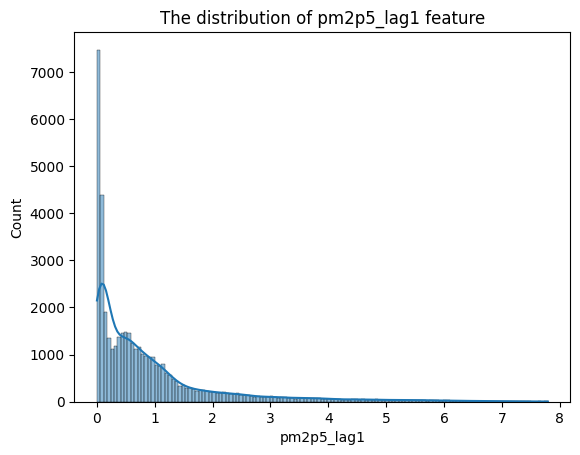

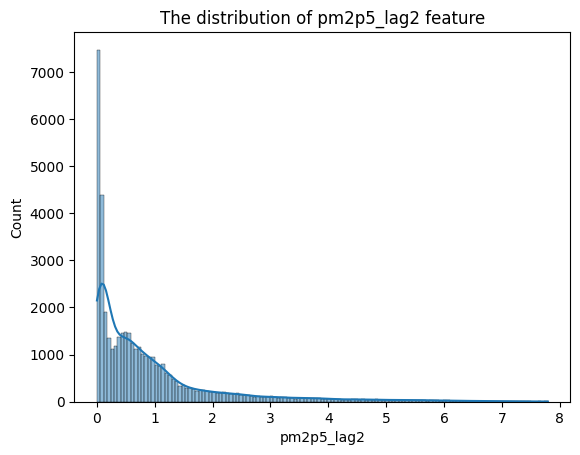

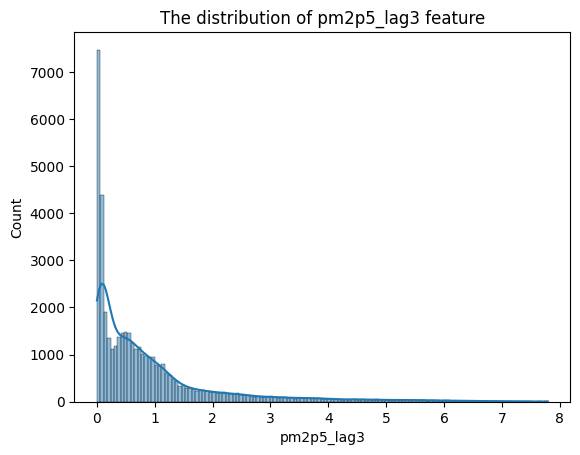

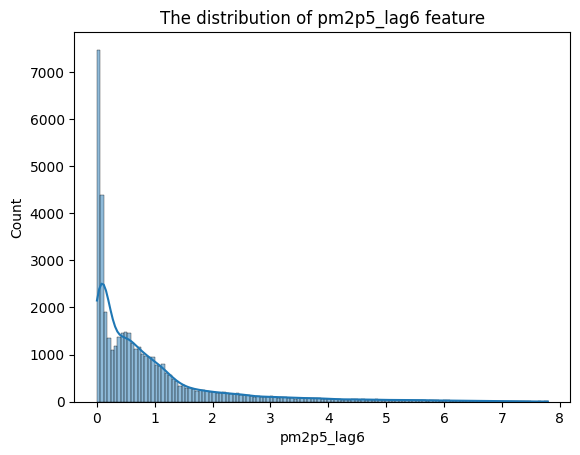

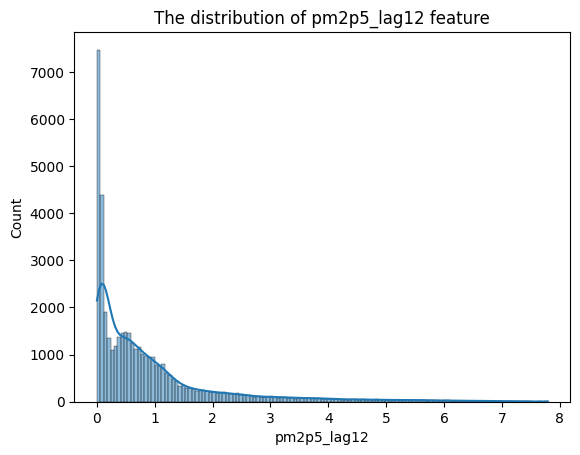

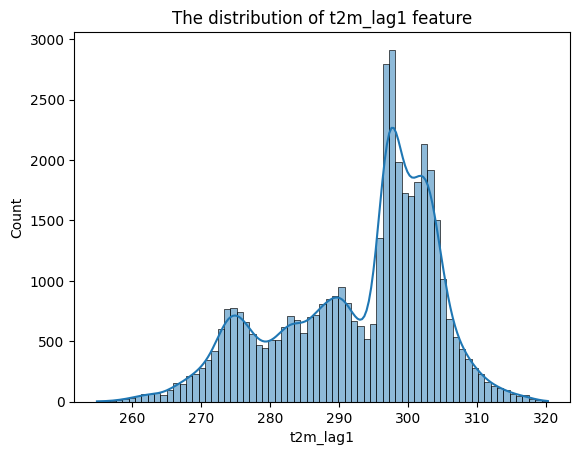

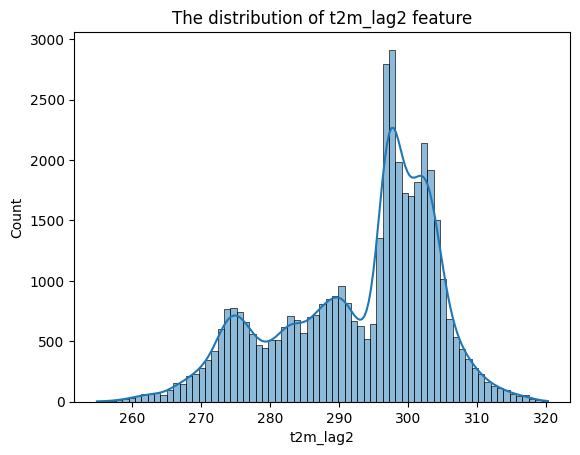

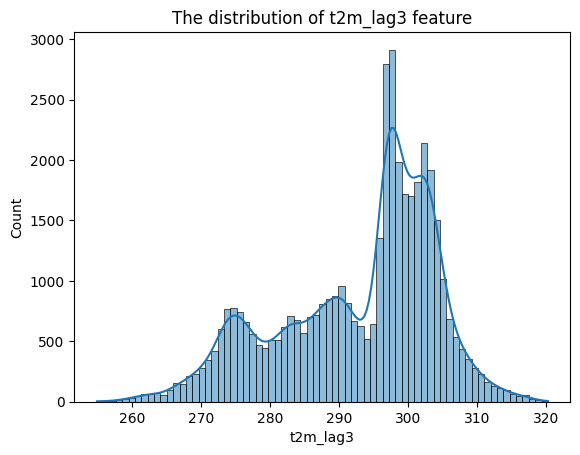

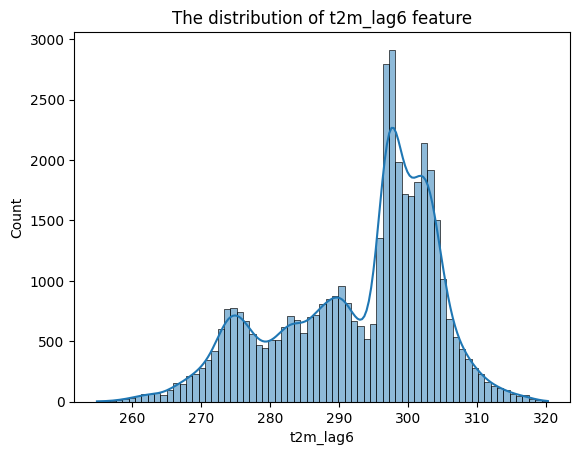

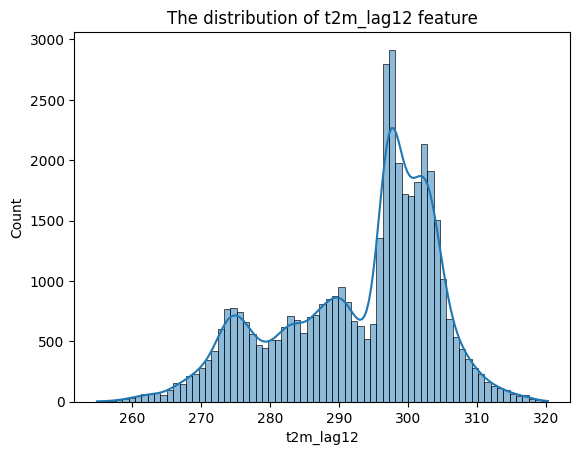

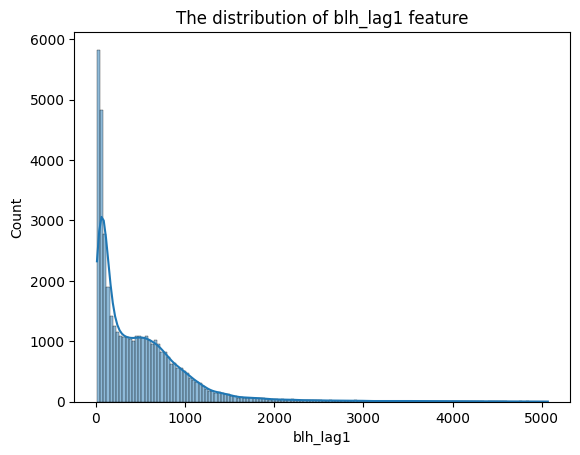

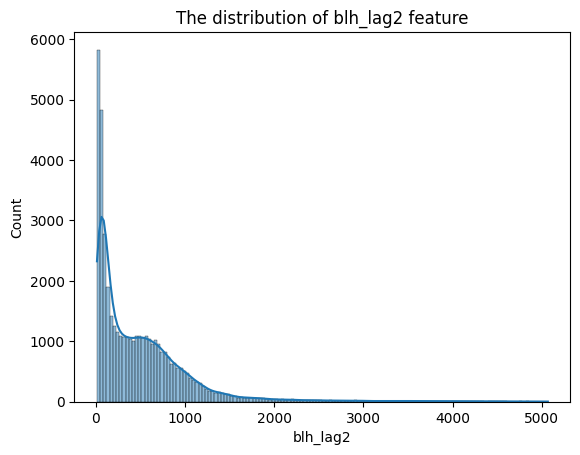

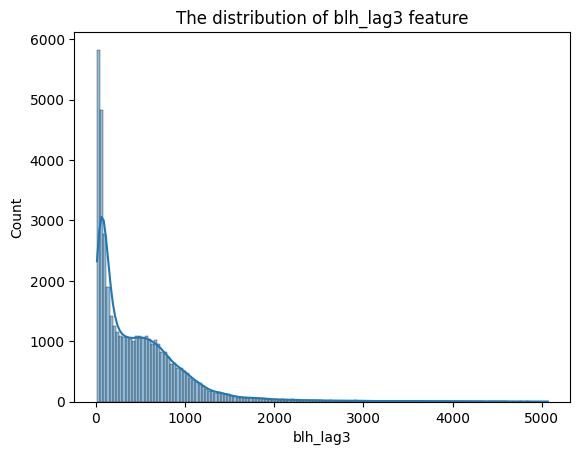

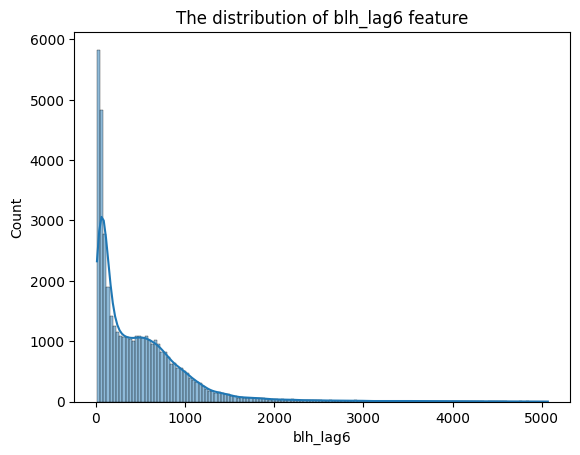

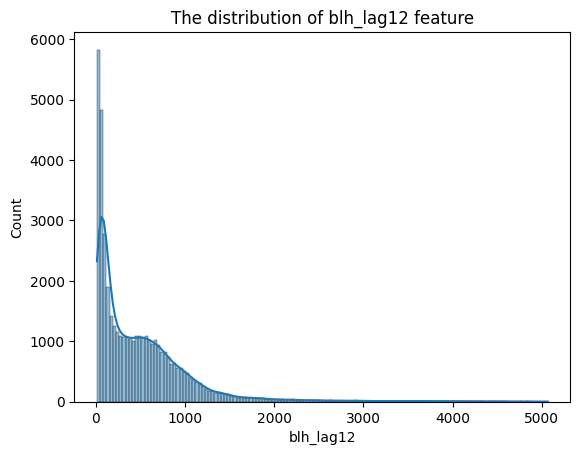

In [12]:
for col in ['pm2p5_lag1', 'pm2p5_lag2', 'pm2p5_lag3', 'pm2p5_lag6', 'pm2p5_lag12', 't2m_lag1', 't2m_lag2', 't2m_lag3', 't2m_lag6', 't2m_lag12', 'blh_lag1', 'blh_lag2', 'blh_lag3', 'blh_lag6', 'blh_lag12']:
  sns.histplot(df[col], kde=True)
  plt.title(f"The distribution of {col} feature")
  plt.show()

In [13]:
data_corr = df.corr(method='pearson')
correlation = data_corr['pm2p5'].sort_values(ascending=False)
correlation

,pm2p5
pm2p5,1.000000
pm2p5_lag1,0.898668
pm2p5_lag2,0.733060
tcso2,0.699668
pm2p5_lag6,0.688717
city_Delhi,0.660505
tcco,0.657355
bcaod550,0.625345
omaod550,0.614994
pm2p5_lag3,0.604714


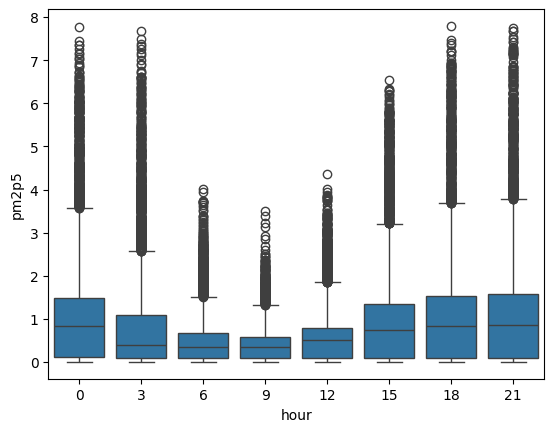

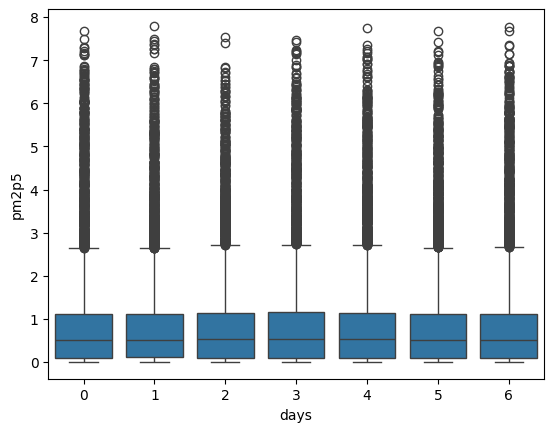

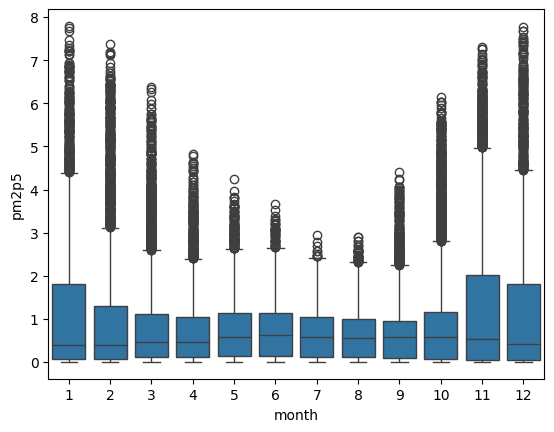

In [14]:
for col in ['hour', 'days', 'month']:
  sns.boxplot(x=col, y='pm2p5', data=df)
  plt.show()

In [15]:
X = df.drop(columns=['valid_time', 'pm2p5'])
y = df['pm2p5']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
minmax_x = MinMaxScaler()
minmax_y = MinMaxScaler()

X_train_minmax = minmax_x.fit_transform(X_train)
X_test_minmax = minmax_x.transform(X_test)

y_train_minmax = minmax_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_minmax = minmax_y.transform(y_test.values.reshape(-1, 1))

In [18]:
xgb_base = XGBRegressor()

In [19]:
xgb_base.fit(X_train_minmax, y_train_minmax)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [20]:
y_pred_base = xgb_base.predict(X_test_minmax)

In [21]:
y_pred_inverse = minmax_y.inverse_transform(y_pred_base.reshape(-1, 1))
y_test_inverse = minmax_y.inverse_transform(y_test_minmax.reshape(-1, 1))

In [22]:
print(f"Base XGBoost Model RMSE Score: {root_mean_squared_error(y_test_inverse, y_pred_inverse)}")
print(f"Base XGBoost Model MAE Score: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"Base XGBoost R2 Score: {r2_score(y_test_inverse, y_pred_inverse)}")

Base XGBoost Model RMSE Score: 0.20356842696085664
Base XGBoost Model MAE Score: 0.10352012936899252
Base XGBoost R2 Score: 0.9698230319888952


In [23]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators': [50, 100, 200, 300],
}

start_training = time.time()
grid_search = GridSearchCV(XGBRegressor(), param_grid,  scoring={ 'rmse': 'neg_root_mean_squared_error', 'mae': 'neg_mean_absolute_error', 'r2': 'r2'}, refit='rmse', cv=5)
grid_search.fit(X_train_minmax, y_train_minmax)
finish_training = time.time()

In [24]:
xgb_bestParam = grid_search.best_params_
print(xgb_bestParam)

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


In [25]:
xgb_bestEstimator = grid_search.best_estimator_

In [26]:
y_pred_grid_search = grid_search.predict(X_test_minmax)

In [27]:
y_pred_gs_inverse = minmax_y.inverse_transform(y_pred_grid_search.reshape(-1, 1))

In [28]:
print(f"Grid Search XGBoost Model RMSE Score: {root_mean_squared_error(y_test_inverse, y_pred_gs_inverse)}")
print(f"Grid Search XGBoost Model MAE Score: {mean_absolute_error(y_test_inverse, y_pred_gs_inverse)}")
print(f"Grid Search XGBoost R2 Score: {r2_score(y_test_inverse, y_pred_gs_inverse)}")

Grid Search XGBoost Model RMSE Score: 0.19068560978603866
Grid Search XGBoost Model MAE Score: 0.09388721953210373
Grid Search XGBoost R2 Score: 0.9735216693593519


In [29]:
y_train_pred = grid_search.predict(X_train_minmax)
inference_start = time.time()
y_test_pred = grid_search.predict(X_test_minmax)
inference_end = time.time()

y_train_inverse = minmax_y.inverse_transform(y_train_minmax)

y_train_pred_inv = minmax_y.inverse_transform(y_train_pred.reshape(-1, 1))
y_test_pred_inv = minmax_y.inverse_transform(y_test_pred.reshape(-1, 1))

print("Grid Search Result")
print(f"Training Data RMSE Score: {root_mean_squared_error(y_train_pred_inv, y_train_inverse)}")
print(f"Training Data MAE Score: {mean_absolute_error(y_train_pred_inv, y_train_inverse)}")
print(f"Training Data R2 Score: {r2_score(y_train_pred_inv, y_train_inverse)}")
print(f"Training Data MAPE Score: {mean_absolute_percentage_error(y_train_pred_inv, y_train_inverse)}")
print()
print(f"Testing Data RMSE Score: {root_mean_squared_error(y_test_pred_inv, y_test_inverse)}")
print(f"Testing Data MAE Score: {mean_absolute_error(y_test_pred_inv, y_test_inverse)}")
print(f"Testing Data R2 Score: {r2_score(y_test_pred_inv, y_test_inverse)}")
print(f"Testing Data MAPE Score: {mean_absolute_percentage_error(y_test_pred_inv, y_test_inverse)}")

Grid Search Result
Training Data RMSE Score: 0.06198430129708495
Training Data MAE Score: 0.03991374527180145
Training Data R2 Score: 0.9971894512780092
Training Data MAPE Score: 0.11815467873791857

Testing Data RMSE Score: 0.19068560978603866
Testing Data MAE Score: 0.09388721953210373
Testing Data R2 Score: 0.9726584839055913
Testing Data MAPE Score: 0.15031553463300917


In [30]:
importances = xgb_bestEstimator.feature_importances_

feature_names = X.columns

feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values('Importance', ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(10))
plt.tight_layout()
plt.savefig("XGBoost_feature_importance.png", dpi=300, bbox_inches='tight')
plt.close()

from google.colab import files
files.download("XGBoost_feature_importance.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
joblib.dump(xgb_base, "Base_Scaled_XGBoost_Air_Quality_Model.pkl")
joblib.dump(grid_search.best_estimator_, "GridSearch_Scaled_XGBoost_Air_Quality_Model.pkl")

['GridSearch_Scaled_XGBoost_Air_Quality_Model.pkl']

# Addition
1. Extracting per-city RMSE  
2. Extracting the Visual Error Analysis
3. Identify the training time and inference time of the XGBoost model
4. Identify the memory usage of the XGBoost model  

In [32]:
data_test = X_test.copy()
data_test['y_real'] = y_test_inverse
data_test['y_pred'] = y_test_pred_inv

data_test['city'] = data_test.filter(like='city_').idxmax(axis=1).str.replace('city_', '')

In [33]:
city_rmse_value = data_test.groupby("city").apply(lambda x: np.sqrt(mean_squared_error(x['y_real'], x['y_pred']))).reset_index(name='rmse')

/tmp/ipython-input-33-136585191.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  city_rmse_value = data_test.groupby("city").apply(lambda x: np.sqrt(mean_squared_error(x['y_real'], x['y_pred']))).reset_index(name='rmse')


In [34]:
city_rmse_value

,city,rmse
0,Delhi,0.318850
1,Helsinki,0.023755
2,Jakarta,0.075939


# Temporal Analysis

Visual Error Analysis (Especially during outlier pollution events)

In [35]:
residuals = y_test_inverse.flatten() - y_test_pred_inv.flatten()

In [36]:
error_df = pd.DataFrame({
    'True_PM2.5': y_test_inverse.flatten(),
    'Residual': residuals
})

In [37]:
threshold = np.percentile(error_df['True_PM2.5'], 95)
error_df['Outlier'] = error_df['True_PM2.5'] >= threshold
error_df['Outlier_Label'] = error_df['Outlier'].map({True: 'Outlier', False: 'Non-Outlier'})

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=error_df, x='True_PM2.5', y='Residual', hue='Outlier_Label', palette={'Outlier': 'red', 'Non-Outlier': 'blue'}, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("PM2.5 (multiplied with 1e7)")
plt.ylabel("Residual")
plt.tight_layout()
# plt.show()
plt.savefig("XGBoost_Visual_Error_Analysis.png", dpi=300)
plt.close()

# Efficiency Benchmarking

In [39]:
training_time = finish_training - start_training
inference_period = inference_end - inference_start
memory = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2

In [40]:
print("Training Time (s): ", training_time)
print("Inference Time (s): ", inference_period)
print("Memory Used: ", memory)

Training Time (s):  580.3261208534241
Inference Time (s):  0.12839531898498535
Memory Used:  698.4375
